# Анализ рекламных источников

Ссылка на презентацию:
https://disk.yandex.ru/i/1pRHqRtvamzlYQ

## Описание проекта

В игре "Космические братья" пользователи строят свою космическую программу и пытаются колонизировать галактики. 

В качестве основного канала монетизации планируется показ рекламы на экране с выбором типа объекта для постройки. 

В представленных заказчиком данных присутствует информация о прохождении первого уровня игроками начавшими пользоваться приложением с 4 по 10 мая включительно.

Завершение первого уровня возможно:

* Путем реализации проекта "Разработка орбитальной станции спутников" (соответствующее событие в наборе данных).
* Путем победы над другим игроком (событие завершения уровня без постройки проекта).

**Цели проекта**:
1. Провести исследовательский анализ данных.
2. Провести анализ влияния источников перехода в игру на потенциальную монетизацию и поведение игроков, а также провести ранжирование источников.
3. Проверить статистические гипотезы:
    * Время завершения уровня различается в зависимости способа прохождения (через реализацию проекта или через победу над другим игроком)
    * Количество построек пользователей, пришедших из Яндекс.Директ различается с количеством построек пользователей, пришедших из Instagram.
    
**План работ**:

0. Обзор данных.
1. Предварительная обработка данных:
    * Обработка пропусков
    * Проверка соответствия типов данных
    * Обработка дубликатов
    * Расчёт дополнительных метрик, необходимых для дальнейшего анализа
2. Исследовательский анализ данных:
    * Исследовать количество событий по дням
    * Исследовать способы завершения первого уровня на общем объеме данных
    * Исследовать способы завершения первого уровня в разрезе источника привлечения
    * Исследовать количество построек пользователей на общем объеме данных
    * Исследовать количество построек пользователей в разрезе источника привлечения
    * Исследовать количество построек пользователей в разрезе способа завершения уровня
    * Исследовать количество пользователей, пришедших из различных каналов привлечения
    * Исследовать стоимость привлечения пользователей из каждого источника
    * Проранжировать источники в разрезе максимизации потенциальной прибыли
3. Проверка гипотез:
    * Проверка гипотезы о различии времени завершения уровня в зависимости способа прохождения
    * Проверка гипотезы о различии количества построек пользователей, пришедших из Яндекс.Директ и Instagram
4. Формулирование общих выводов.
5. Подготовка презентации.
6. Подготовка дашборда, содержащего:
    * диаграмму распределения количества построенных объектов
    * индикатор количества пользователей
    * фильтр по типу события

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

## Описание данных

Датасет *game_actions.csv*:

- `event_datetime` — время события;
- `event` — одно из трёх событий:
    1. `building` — объект построен,
    2. `finished_stage_1` — первый уровень завершён,
    3. `project` — проект завершён;
- `building_type` — один из трёх типов здания:
    1. `assembly_shop` — сборочный цех,
    2. `spaceport` — космопорт,
    3. `research_center` — исследовательский центр;
- `user_id` — идентификатор пользователя;
- `project_type` — тип реализованного проекта;

Датасет *ad_costs.csv*:

- `day` - день, в который был совершен клик по объявлению
- `source` - источник трафика
- `cost` - стоимость кликов

Датасет user_source.csv содержит колонки:

- `user_id` - идентификатор пользователя
- `source` - источников, с которого пришёл пользователь, установивший приложение

## Импорт и обзор данных

In [2]:
adcost = pd.read_csv('/datasets/ad_costs.csv')
action = pd.read_csv('/datasets/game_actions.csv')
user = pd.read_csv('/datasets/user_source.csv')

In [3]:
display(adcost.head())
adcost.info()
print(f'Список уникальных источников: {adcost.source.unique()}')

,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes
Список уникальных источников: ['facebook_ads' 'instagram_new_adverts' 'yandex_direct'
 'youtube_channel_reklama']


В данных отсутствуют пропуски. Атрибут `day` требует приведения к типу `datetime`.

In [4]:
display(action.head())
action.info()

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


В данных присутствуют пропуски, которые необходимо изучить детальнее. Атрибут `event_datetime` требует приведения к типу `datetime`.

In [5]:
display(user.head())
user.info()
print(f'Список уникальных источников: {user.source.unique()}')

,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB
Список уникальных источников: ['facebook_ads' 'yandex_direct' 'youtube_channel_reklama'
 'instagram_new_adverts']


В данных отсуствуют пропуски, типы данных приведения не требуют, в общем наборе данных учтена информация по всем источникам.

**Вывод**: данные пригодны для дальнейшего анализа, однако требуют предварительной обработки.

## Предварительная обработка данных

### Датасет ad_costs

Проверим набор данных на наличие дубликатов:

In [6]:
print('Количество дубликатов в adcost:', adcost.duplicated().sum())

Количество дубликатов в adcost: 0


Пропуски и дубликаты отсутствуют. Приведем тип данных:

In [7]:
adcost['day'] = pd.to_datetime(adcost['day'])
print(f'Минимальная дата: {adcost.day.min()}, максимальная дата: {adcost.day.max()}')
adcost.info()

Минимальная дата: 2020-05-03 00:00:00, максимальная дата: 2020-05-09 00:00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   source  28 non-null     object        
 1   day     28 non-null     datetime64[ns]
 2   cost    28 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 800.0+ bytes


**Вывод**: набор данных ad_costs обработан и полностью готов для дальнейшего анализа.

### Датасет user

Проверим набор данных на наличие дубликатов:

In [8]:
print('Количество дубликатов в user:', user.duplicated().sum())

Количество дубликатов в user: 0


Проверим уникальность канала привлечения для каждого пользователя:

In [9]:
user.groupby('user_id')['source'].count().to_frame().reset_index().sort_values(by='source', ascending=False).head(1)

,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,1


**Вывод**: пропуски и дубликаты отсутствуют, типы данных соответствуют требуемым, каждому пользователю соответствует единственный канал привлечения. Набор данных не требует предварительной обработки.

### Датасет action

Проверим набор данных на наличие дубликатов:

In [10]:
print('Количество дубликатов в action:', action.duplicated().sum())

Количество дубликатов в action: 1


В данных присутствует 1 дубликат. Устраним его:

In [11]:
action.drop_duplicates(inplace=True)

Приведем тип данных event_datetime к требуемому:

In [12]:
action['event_datetime'] = pd.to_datetime(action['event_datetime'])
print(f'Минимальная дата: {adcost.day.min()}, максимальная дата: {adcost.day.max()}')

Минимальная дата: 2020-05-03 00:00:00, максимальная дата: 2020-05-09 00:00:00


Обработаем пропуски в данных. Начнем с поля project_type:

In [13]:
action.project_type.unique()

array([nan, 'satellite_orbital_assembly'], dtype=object)

Данное поле содержит только одно непустое значение "satellite_orbital_assembly". Данные пропуски обрабатывать не нужно, они полностью корректны.

Обработаем пропуски в building_type:

In [14]:
action.query('building_type.isna()').head()
print('Всего пропусков:', len(action.query('building_type.isna()')))

Всего пропусков: 7683


Эти пропуски выглядят, как маркеры завершение уровня. Проверим данное утверждение.

In [15]:
print('Количество пропусков. Завершение первого уровня:', len(action.query('building_type.isna() and event == "finished_stage_1"')))
print('Количество пропусков. Завершение проекта:',len(action.query('building_type.isna() and event == "project" and project_type == "satellite_orbital_assembly"')))

Количество пропусков. Завершение первого уровня: 5817
Количество пропусков. Завершение проекта: 1866


Таким образом, можно утверждать, что пропуски в building_type также являются корректными (т.е. 5817 игроков завершили первый уровень, из них 1866 завершили проект + для них же 1866 событий завершения уровня после проекта) и являются маркером пропуска на следующий уровень. Пропуски можно заполнить значением "next_level" для дальнейшего удобства.

In [16]:
action.building_type.fillna('next_level', inplace=True)

## Расчёт дополнительных метрик

Теперь необходимо для каждого пользователя рассчитать: дату первого действия, дату последнего действия, разницу в датах в секундах, количество построенных зданий, тип перехода и стоимость привлечения.

Расчёт времени первого и последнего действия:

In [17]:
user_date = action.groupby('user_id').agg({'event_datetime':['min', 'max']}).reset_index()
user_date.columns = ['user_id', 'first_action', 'last_action']
user_date['timedelta'] = (user_date.last_action - user_date.first_action).astype('timedelta64[s]')
user_date.head()

,user_id,first_action,last_action,timedelta
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06 01:07:37,2020-05-20 11:26:06,1246709.0
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06 03:09:12,2020-05-18 10:46:52,1064260.0
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05 18:08:52,2020-05-14 09:21:27,745955.0
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,2020-05-12 07:40:47,556722.0
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05 13:49:58,2020-05-22 02:46:45,1429007.0


Расчёт количества построек:

In [18]:
user_buildings = action.query('event == "building" ').groupby('user_id')['event_datetime'].count().to_frame().reset_index()
user_buildings.columns = ['user_id', 'buildings']
user_buildings.head()

,user_id,buildings
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,13
1,00151b4f-ba38-44a8-a650-d7cf130a0105,9
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,4
3,001d39dc-366c-4021-9604-6a3b9ff01e25,8
4,002f508f-67b6-479f-814b-b05f00d4e995,12


Расчёт стоимости привлечения пользователей. Условимся допущением, что первое действие в игре было совершено в день клика по объявлению.

In [20]:
user_date['first_day'] = pd.to_datetime(user_date.first_action.dt.date)
user_cost = user_date.copy()
user_cost = (user_cost.merge(user, on='user_id', how='inner')
             .groupby(['source'])['user_id'].count()
             .reset_index())
user_cost.columns = ['source', 'num_of_users']
user_cost = user_cost.merge(adcost, on=['source'], how='inner')
user_cost = user_cost.groupby('source').agg({'num_of_users':['min'], 'cost':'sum'}).reset_index()
user_cost.columns = ['source', 'num_of_users', 'cost']
user_cost['one_user_cost'] = user_cost.cost / user_cost.num_of_users
user_cost.head()

,source,num_of_users,cost,one_user_cost
0,facebook_ads,2726,2140.904643,0.785365
1,instagram_new_adverts,3347,2161.441691,0.645785
2,yandex_direct,4817,2233.111449,0.463590
3,youtube_channel_reklama,2686,1068.119204,0.397662


Расчёт способа перехода на следующий уровень для каждого пользователя:

In [21]:
user_next = pd.concat([action[action['project_type'] == 'satellite_orbital_assembly'],
                              action[action['event'] == 'finished_stage_1']], ignore_index=True)
user_next.loc[user_next.project_type.isna(), 'finish'] = 0
user_next.loc[user_next.project_type == 'satellite_orbital_assembly', 'finish'] = 1
user_next = user_next.groupby('user_id')['finish'].max().to_frame().reset_index()
user_next.head()

,user_id,finish
0,001d39dc-366c-4021-9604-6a3b9ff01e25,0.0
1,003ee7e8-6356-4286-a715-62f22a18d2a1,0.0
2,004074f8-251a-4776-922c-8348dca1a2f6,0.0
3,00464e5e-28ed-4be6-bf44-517ef7b3937b,0.0
4,0056c007-c082-43cc-bdef-afc49bca4cb9,0.0


Объединим полученные данные:

In [22]:
df = (user_date.merge(user, on='user_id', how='left')
          .merge(user_cost, on = 'source', how='left')
          .merge(user_buildings, on='user_id', how='left')
          .merge(user_next, on='user_id', how='left'))
df.drop(['first_action', 'last_action', 'first_day', 'num_of_users', 'cost'], axis=1, inplace=True)
df['finish'].replace({1:'project', 0:'win'}, inplace=True)
df['finish'].fillna('no_transition', inplace=True)
df.head()

,user_id,timedelta,source,one_user_cost,buildings,finish
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,1246709.0,facebook_ads,0.785365,13,no_transition
1,00151b4f-ba38-44a8-a650-d7cf130a0105,1064260.0,yandex_direct,0.463590,9,no_transition
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,745955.0,youtube_channel_reklama,0.397662,4,no_transition
3,001d39dc-366c-4021-9604-6a3b9ff01e25,556722.0,instagram_new_adverts,0.645785,8,win
4,002f508f-67b6-479f-814b-b05f00d4e995,1429007.0,facebook_ads,0.785365,12,no_transition


## Исследовательский анализ данных

### Количество событий по дням

In [23]:
action['day'] = action.event_datetime.dt.date

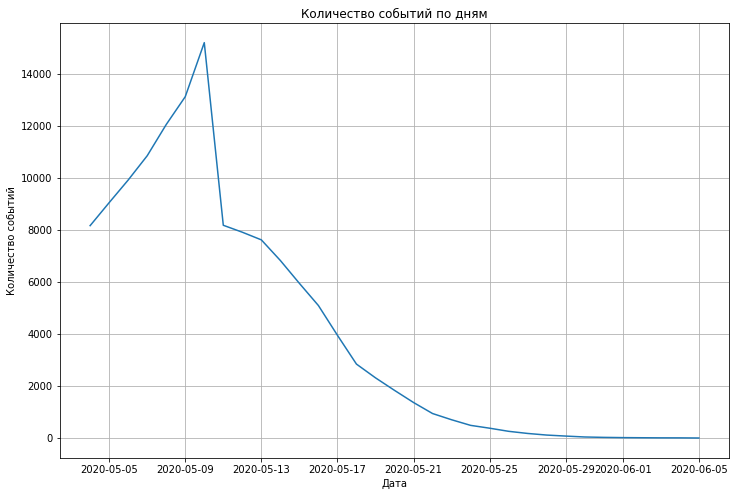

In [24]:
plt.figure(figsize=(12,8));
action.groupby('day')['event'].count().plot(grid=True);
plt.title('Количество событий по дням');
plt.xlabel('Дата');
plt.ylabel('Количество событий');

**Вывод**: на данном графике вполне закономерный результат. Самое большое количество действий приходится на первый игровой день, а затем количество действий в игре уменьшается. Пик приходится на 10 мая, когда и закончился набор новых пользователей в когорту. Таким образом убеждаемся, что нет никаких аномальных всплесков.

### Способы завершения первого уровня

#### Способы завершения на всем объеме данных

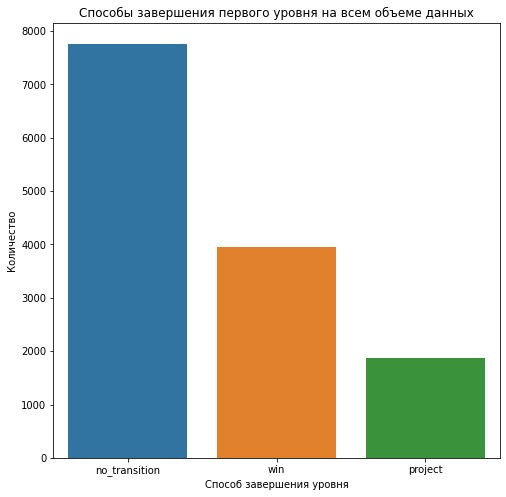

In [25]:
plt.figure(figsize=(8,8));
sns.countplot(data=df, x='finish');
plt.title('Способы завершения первого уровня на всем объеме данных');
plt.xlabel('Способ завершения уровня');
plt.ylabel('Количество');

#### Способы завершения в разрезе источника привлечения

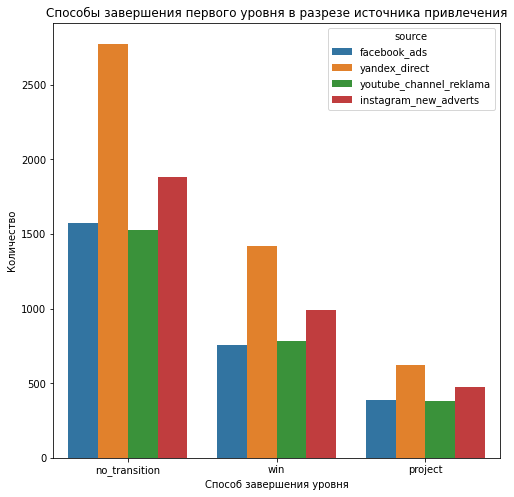

In [26]:
plt.figure(figsize=(8,8));
sns.countplot(data=df, x='finish', hue='source');
plt.title('Способы завершения первого уровня в разрезе источника привлечения');
plt.xlabel('Способ завершения уровня');
plt.ylabel('Количество');

**Вывод**:

1. Б**о**льшая часть новопришедших игроков не завершает первый уровень.
2. Б**о**льшая часть игроков приходит из Яндекс.Директ.
3. Более распространенный способ перехода на второй уровень - победа над другим игроком. В таком случае, можно рассматривать дополнительные каналы монетизации, связанные именно с этим способом.
4. Способ завершения первого уровня принципиально не различается для разных источников привлечения.

### Исследование количества построек

#### Количество построек на всем объеме данных

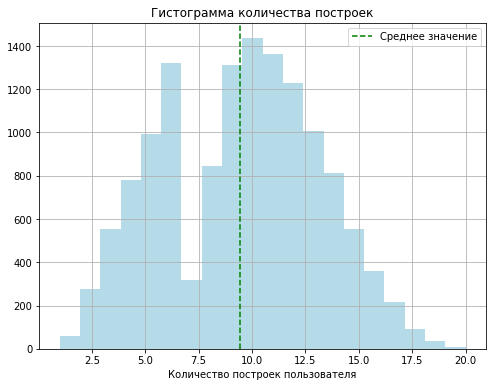

In [27]:
plt.figure(figsize=(8,6));
df.buildings.hist(bins=20, color='lightblue', alpha=0.9);
plt.axvline(df.buildings.mean(), color='green', linestyle='--', label='Среднее значение');
plt.title('Гистограмма количества построек');
plt.xlabel('Количество построек пользователя');
plt.legend();

#### Количество построек в разрезе канала привлечения

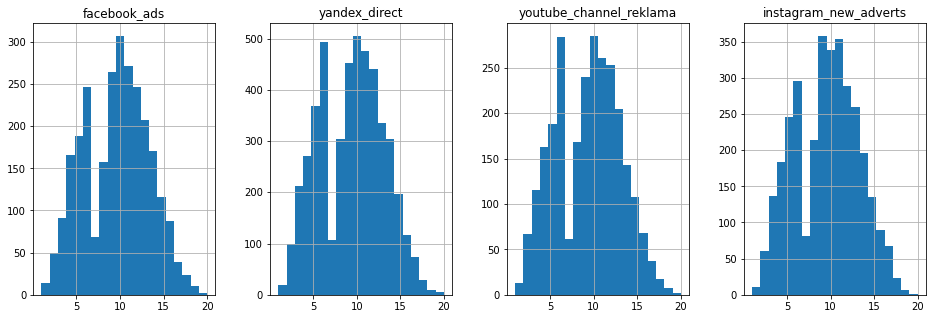

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 5))
i = 0
for x in df.source.unique():
    df.loc[df.source == x, 'buildings'].to_frame().hist(bins=20, ax=axes[i])
    axes[i].title.set_text(x)
    i+=1

#### Количество построек в разрезе способа завершения уровня

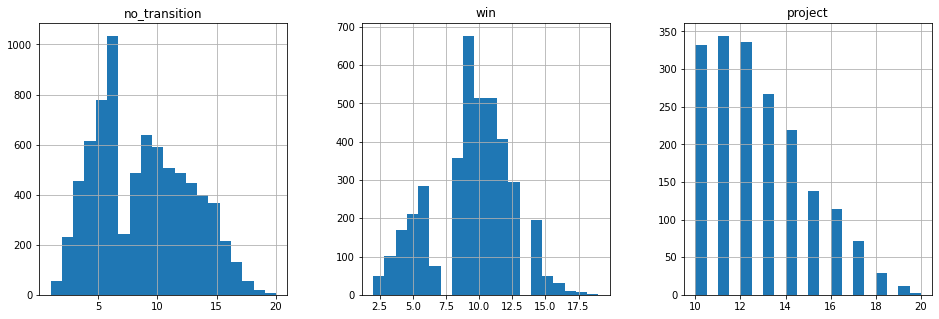

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
i = 0
for x in df.finish.unique():
    df.loc[df.finish == x, 'buildings'].to_frame().hist(bins=20, ax=axes[i])
    axes[i].title.set_text(x)
    i+=1

**Вывод**: распределение количества построек как в целом, так и в разрезе источника можно было бы считать очень похожим на нормальное, если бы не провал на уровне 7 построек. Можно предположить, что начиная именно с 7 постройки игра начинает усложняться, что приводит к провалу. В среднем, игроки на 1 уровне строят около 9 объектов. Вполне вероятно, что именно на этом этапе следует предлагать более активную монетизацию, т.к. это может помочь игрокам преодолеть "провал". Важно отметить, что количество построек игроков, которые заканчивают первый уровень проектом, значительно выше остальных и они также являются целью планируемой монетизации.

### Исследование каналов привлечения

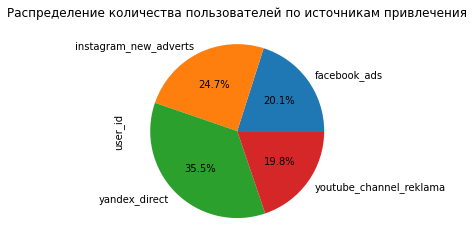

In [30]:
df.groupby('source')['user_id'].count().to_frame().plot(kind='pie', 
                                           x='source', y='user_id', 
                                           autopct='%1.1f%%', legend=False);
plt.title('Распределение количества пользователей по источникам привлечения');

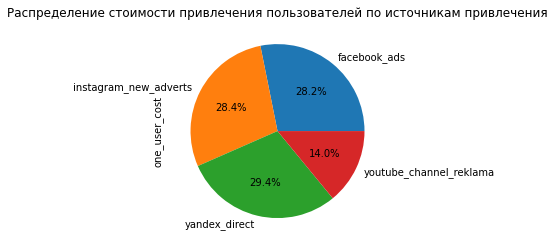

In [31]:
df.groupby('source')['one_user_cost'].sum().to_frame().plot(kind='pie', 
                                           x='source', y='one_user_cost', 
                                           autopct='%1.1f%%', legend=False);

plt.title('Распределение стоимости привлечения пользователей по источникам привлечения');

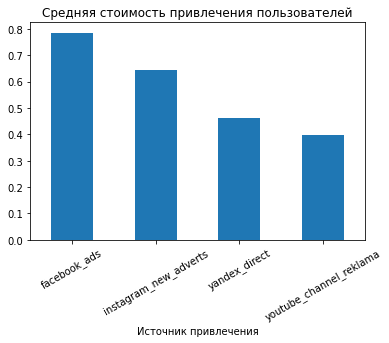

In [32]:
plt.title('Средняя стоимость привлечения пользователей');
df.groupby('source')['one_user_cost'].mean().plot.bar();
plt.xticks(rotation=30);
plt.xlabel('Источник привлечения');

**Вывод**: нетрудно заметить, что большинство пользователей привлекается из Яндекс.Директа, при этом это одни из самых дешевых пользователей. При этом самым дешевым каналом является Youtube, но доля пользователей из данного канала самая низкая. Instagram и Facebook - самые дорогие каналы привлечения. Из них привлечено около 25% и 20% соответственно. Полученную информацию важно учитывать при выделении самых выгодных каналов привлечения.

### Исследование времени прохождения первого уровня

#### Время прохождения первого уровня на общем объеме данных

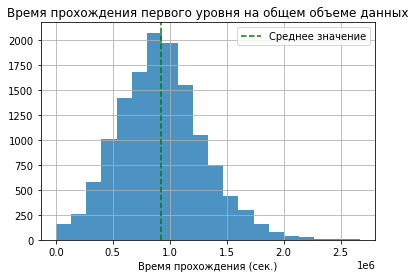

In [33]:
df.timedelta.hist(bins=20, alpha=0.8);
plt.title('Время прохождения первого уровня на общем объеме данных');
plt.xlabel('Время прохождения (сек.)');
plt.axvline(df.timedelta.mean(), color='green', linestyle='--', label='Среднее значение');
plt.legend();

#### Время прохождения первого уровня в разрезе канала привлечения

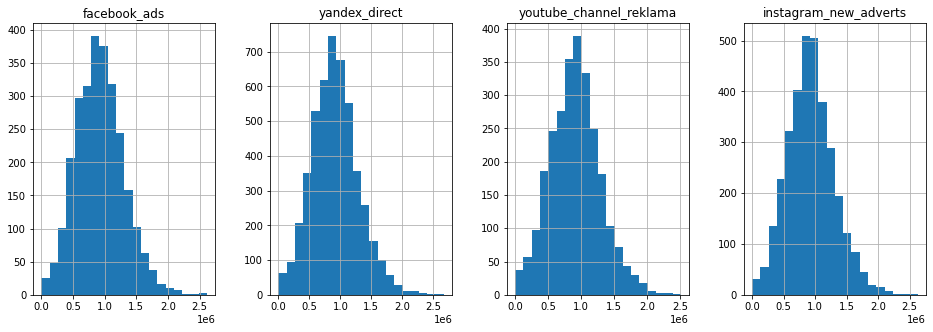

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 5))
i = 0
for x in df.source.unique():
    df.loc[df.source == x, 'timedelta'].to_frame().hist(bins=20, ax=axes[i])
    axes[i].title.set_text(x)
    i+=1

**Вывод**: в среднем, на прохождение первого уровня тратится около 10 дней независимо от канала привлечения.

## Проверка гипотез

Так как исследование не является высокоточным, примем уровень значимости равный 0.05.

In [35]:
alpha = .05

### О различии времени завершения уровня в зависимости способа прохождения

Первая гипотеза заключается в том, что время завершения первого уровня отличается в зависимости от способа прохождения (т.е. через победу или проект).

**H0**: среднее время завершения первого уровня не различается в зависимости от способа прохождения.

**H1**: среднее время завершения первого уровня различается в зависимости от способа прохождения.

**Метод проверки**: t-test Стьюдента (считаем дисперсии генеральных совокупностей равными, т.к. нет оснований считать обратное)

Подготовка данных:

In [36]:
df_test_1_1 = df.query('finish == "win" and timedelta != 0')
df_test_1_2 = df.query('finish == "project" and timedelta != 0')

Проверяем распределения:

Среднее значение времени прохождения через победу: 959424.08 (сек.)
Медианное значение времени прохождения через победу: 932497.0 (сек.)


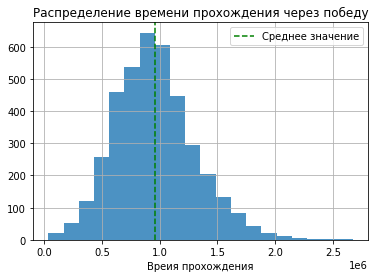

In [37]:
df_test_1_1.timedelta.hist(bins=20, alpha=0.8);
plt.title('Распределение времени прохождения через победу');
plt.xlabel('Вреия прохождения')
plt.axvline(df_test_1_1.timedelta.mean(), color='green', linestyle='--', label='Среднее значение');
plt.legend();
print(f'Среднее значение времени прохождения через победу: {round(df_test_1_1.timedelta.mean(),2)} (сек.)')
print(f'Медианное значение времени прохождения через победу: {round(df_test_1_1.timedelta.median(),2)} (сек.)')

Среднее значение времени прохождения через проект: 1162849.14 (сек.)
Медианное значение времени прохождения через проект: 1125941.0 (сек.)


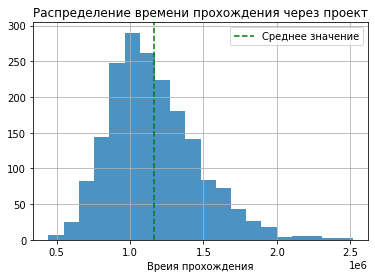

In [38]:
df_test_1_2.timedelta.hist(bins=20, alpha=0.8);
plt.title('Распределение времени прохождения через проект');
plt.xlabel('Вреия прохождения')
plt.axvline(df_test_1_2.timedelta.mean(), color='green', linestyle='--', label='Среднее значение');
plt.legend();
print(f'Среднее значение времени прохождения через проект: {round(df_test_1_2.timedelta.mean(),2)} (сек.)')
print(f'Медианное значение времени прохождения через проект: {round(df_test_1_2.timedelta.median(),2)} (сек.)')

Статистический тест:

In [39]:
results = st.ttest_ind(
    df_test_1_1.timedelta, 
    df_test_1_2.timedelta)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу о равестве ")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 7.256845329495443e-98
Отвергаем нулевую гипотезу о равестве 


**Вывод**: нулевая гипотеза была отвергнута, следовательно, можно утверждать, что среднее время прохождения первого уровня через победу и через проект статистически значимо различается. В среднем, через проект завершение первого уровня длится дольше.

### О различии количества построек пользователей, пришедших из Яндекс.Директ и Instagram

Вторая гипотеза заключается в том, что количество построек пользователей, пришедших через Яндекс.Директ и Instagram различаются.

**H0**: среднее количество построек не различается в зависимости канала привлечения (Яндекс.Директ или Instagram).

**H1**: среднее количество построек различается в зависимости канала привлечения (Яндекс.Директ или Instagram).

**Метод проверки**: t-test Стьюдента (считаем дисперсии генеральных совокупностей равными, т.к. нет оснований считать обратное)

Подготовка данных:

In [40]:
df_test_2_1 = df.query('source == "yandex_direct"')
df_test_2_2 = df.query('source == "instagram_new_adverts"')

Проверяем распределения:

Среднее значение количества построек Яндекс.Директ: 9.35
Медианное значение количества построек Яндекс.Директ: 10.0


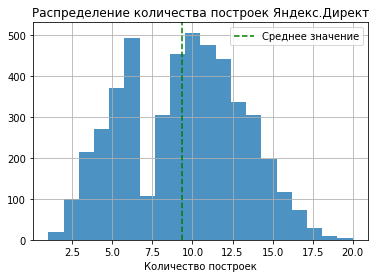

In [41]:
df_test_2_1.buildings.hist(bins=20, alpha=0.8);
plt.title('Распределение количества построек Яндекс.Директ');
plt.xlabel('Количество построек')
plt.axvline(df_test_2_1.buildings.mean(), color='green', linestyle='--', label='Среднее значение');
plt.legend();
print(f'Среднее значение количества построек Яндекс.Директ: {round(df_test_2_1.buildings.mean(),2)}')
print(f'Медианное значение количества построек Яндекс.Директ: {round(df_test_2_1.buildings.median(),2)}')

Среднее значение количества построек Instagram: 9.51
Медианное значение количества построек Instagram: 10.0


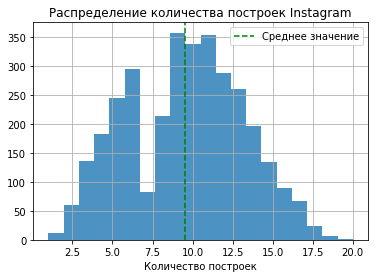

In [42]:
df_test_2_2.buildings.hist(bins=20, alpha=0.8);
plt.title('Распределение количества построек Instagram');
plt.xlabel('Количество построек')
plt.axvline(df_test_2_2.buildings.mean(), color='green', linestyle='--', label='Среднее значение');
plt.legend();
print(f'Среднее значение количества построек Instagram: {round(df_test_2_2.buildings.mean(),2)}')
print(f'Медианное значение количества построек Instagram: {round(df_test_2_2.buildings.median(),2)}')

Статистический тест:

In [43]:
results = st.ttest_ind(
    df_test_2_1.buildings, 
    df_test_2_2.buildings)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу о равестве ")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.06989780662351841
Не получилось отвергнуть нулевую гипотезу


**Вывод**: не получилось отвергнуть нулевую гипотезу о равенстве количества построек пользователей, привлеченных из Instagram и Яндекс.Директ, однако стоит обратить внимание, что p-value располагается очень близко к пороговому.

## Выводы и рекомендации

В ходе выполнения работы были проделаны следующие этапы:
1. Проведен обзор данныхпри это
2. Проведена предварительная обработка данных
3. Рассчитаны дополнительные метрики и данные приведены к удобной для анализа форме.
4. Проведен исследовательский анализ данных в результате которого:
    * Рассмотрена динамика количества событий по дням
    * Под различными углами рассмотрены способы завершение первого уровня игры
    * Исследовано количество построек в различных разрезах
    * Изучены каналы привлечения игроков
    * Рассмотрено влияние различных факторов на время прохождения первого уровня
5. Проверены статистические гипотезы:
    * О различии времени завершения уровня в зависимости способа прохождения
    * О количества построек пользователей, пришедших из Яндекс.Директ и Instagram
6. По результатам исследования подготовлена [презентация](https://disk.yandex.ru/i/1pRHqRtvamzlYQ) и дашборд.

**Ключевые выводы**:
1. Пик по количеству действий игроков приходится на 10 мая, когда закончился набор участников когорты.
2. Большинство новопришедших игроков не завершает первый уровень.
3. По большей части, игроки предпочитают проекту победу над другим игроком для перехода на следующий уровень.
4. Способ завершения первого уровня принципиально не различается для разных источников привлечения, т.е. соотношение "не завершил уровень" - "победа" - "проект" приблизительно одинаковое.
5. Игроки, которые заканчивают первый уровень через проект в среднем строят намного больше игровых зданий, чем остальные игроки. Минимальное количество построек у игроков, которые не закончили первый уровень.
6. Довольно малое количество игроков строит 7 зданий (отчетливо виден провал на графике). В случае, если этот этап становится затруднительным для игроков, это может привести к оттоку. Данный кейс требует дополнительного рассмотрения.
7. Количество построенных зданий принципиально не зависит от канала привлечения.
8. Наибольший поток игроков приходит из канала Яндекс.Директ (более 35%). Этот же канал является одним из самых дешевых. Facebook и Instagram совместно приносят около 45% пользователей, при этом средняя стоимость привлечения из этих каналов в 1.5 - 2 раза выше, чем из Youtube и Яндекс.Директ. Самым дешевым каналом привлечения является Youtube, но его доля занимает всего менее 20% от привлеченных пользователей.
9. В среднем, на прохождение первого уровня у пользователей тратится около 10 дней независимо от канала привлечения.
10. Время завершения уровня статистически значимо различается в зависимости от способа завершения первого уровня. В среднем, через проект завершать уровень дольше.
11. Количество построек пользователей, пришедших из Яндекс.Директ и Instagram статистически значимо не различается.

**Рекомендации**:
1. Возможно, следует упростить механику прохождения первого уровня для повышения вовлеченности в игровой процесс.
2. Следует отдавать предпочтение каналам привлечения Яндекс.Директ и Youtube, так как игроки, пришедшие оттуда стоят дешевле остальных, но при этом поведение игроков принципиально не отличается во всех источниках привлечения. Каналы Facebook и Instagram существенно дороже, при этом приводят суммарно не более половины пользователей.
3. Способ монетизации через показ объявлений с выбором типа постройки является потенциально хорошим, однако наибольшую эффективность, вероятно, он будет показывать на игроках, которые планируют завершать уровень через проект. Таким образом при введении данного типа монетизации следует дополнительно стимулировать игроков к развитию проектов.